In [1]:
cd SRS/

d:\Documentos\ic_tps\SRS


In [2]:
import numpy as np
from srs import SM2
from Evolutivo.evolutivo import GA
from tqdm import tqdm
from utils import fitness

n_bits = 30

# Alfa, Umbral, Phi(5), Psi(5)
var_bits = np.ones(12, dtype=int) * 30
var_lims = np.zeros(13, dtype=int)
var_lims[:-1] = np.arange(0, 12) * var_bits
var_lims[-1] = int(n_bits*12)
var_min  = np.array(
    [0, 0, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5]
)
var_max  = np.array(
    [5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
)

interrev = 1 * 24 * 3600
nvent = 5
ancho_ventanas = np.exp( np.log(15) / nvent * np.arange(1, nvent+1))
ancho_ventanas *= (24 * 3600)

In [3]:
def DecoDecimal(v, a=var_min, b=var_max):
    vs = []
    for i in range(len(var_lims)-1):
        vs.append(v[var_lims[i]:var_lims[i+1]])

    xs = []
    xs = np.zeros(a.size)

    for (i,vi) in enumerate(vs):
        k = len(vi)
        d = sum(2**(k-np.array(range(1,k+1)))*vi)
        xs[i] = a[i] + (d*((b[i]-a[i])/((2**k)-1)))

    return xs

In [4]:
cd ..

d:\Documentos\ic_tps


In [5]:
#Cargar las matrices m_t, m_c, m_s y a lens
m_t = np.load('SRS/data/times.npy')
m_c = np.load('SRS/data/correct.npy')
m_s = np.load('SRS/data/seen.npy')
m_d = np.load('SRS/data/lexemes_dificulty.npy')
lens = np.load('SRS/data/len_schedule.npy')
lens = lens.astype(int)

#Cargamos los acums ("ASCO")
m_acum_cs = np.load('SRS/data/acum_c-res1000-sigma30.npy')
m_acum_ss = np.load('SRS/data/acum_s-res1000-sigma30.npy')

# NUMEROS MAGICOS
N = m_t.shape[0]    #Cantidad total de schedules
n = 100              #Cantidad de schedules para cada individuo

# Inicializamos la clase SRGA, que preprocesa los datos si hace falta
SM2.init_class(lens, m_t, m_c, m_s, m_d)

In [6]:
# Calculamos particiones
N_parts = 5
prct_train = .80
len_part_train = int(N*prct_train)

parts_train = []
parts_test = []

idx = np.arange(0, N)

for i in range(N_parts):
    np.random.shuffle(idx)

    parts_train.append(list(idx[:len_part_train]))
    parts_test.append(list(idx[len_part_train:]))


In [7]:
print(f"Schedules entrenamiento: {len(parts_train[1])}")
print(f"Schedules testeo: {len(parts_test[1])}")
print(f"Schedules totales: {len(parts_test[1])+len(parts_train[1])}")

Schedules entrenamiento: 4993
Schedules testeo: 1249
Schedules totales: 6242


In [8]:
mejores_fitnesses = []
v_part_fitness = []
part_alfa = []
part_beta = []
part_gamma = []

#Usar particiones de entrenamiento
print("ENTRENAMIENTO....")
for j, part in tqdm(enumerate(parts_train)):
    # Definimos la funcion de fitness a utilizar (depende de algunos datos cargados)
    def f_fitness(vars):
        alfa = vars[0]
        beta = vars[1]
        gamma = vars[2]

        v_apts = np.zeros(n)
        scheds = np.random.choice(part, size=n)

        for i, s in enumerate(scheds):
            l = lens[s]
            if m_t[s,l-1] < interrev:
                continue

            sm2 = SM2(alfa, beta, gamma)
            v_apts[i] = fitness(s, m_t[s,:l], m_acum_cs[s, -1], m_acum_ss[s, -1], srs=sm2)
            
        return np.average(v_apts)
        
    # Definimos parametros a usar en el evolutivo
    evolutivo_kwargs = {
                    'N'                : 30,
                    'v_var'            : var_bits,
                    'probCrossOver'    : 0.9,
                    'probMutation'     : 0.2,
                    'f_deco'           : DecoDecimal,
                    'f_fitness'        : f_fitness,
                    'maxGens'          : 50,
                    'debugLvl'         : 90,
    }

    #Evolucionamos
    ga = GA(**evolutivo_kwargs)
    ga.Evolve(elitismo=True, brecha=.4)
        
    # Guardamos datos
    bestAgent = DecoDecimal(ga.bestAgent)
    part_alfa.append(bestAgent[0])
    part_beta.append(bestAgent[1])
    part_gamma.append(bestAgent[2])
    mejores_fitnesses.append(ga.bestFitness)
    v_part_fitness.append(ga.v_bestFitness)

    print(f"INFO PARTICION {j+1}:")
    print(f"MEDIA: {np.mean(ga.v_bestFitness)}")
    print(f"STD: {np.std(ga.v_bestFitness)}")
    print(f"MEDIANA: {np.median(ga.v_bestFitness)}")
    print(f"MAX: {np.max(ga.v_bestFitness)}")
    print(f"MIN: {np.min(ga.v_bestFitness)}\n\n")

ENTRENAMIENTO....
0it [00:00, ?it/s]
100%|██████████| 50/50 [01:55<00:00,  2.34s/it]INFO PARTICION 1:
MEDIA: 0.07766179843907114
STD: 0.008930922848281187
MEDIANA: 0.07639925007890293
MAX: 0.1064187258017406
MIN: 0.06439759382886279


1it [01:55, 115.53s/it]
100%|██████████| 50/50 [01:54<00:00,  2.25s/it]INFO PARTICION 2:
MEDIA: 0.07722996113838547
STD: 0.00763968867789197
MEDIANA: 0.07586295772107685
MAX: 0.10031474177240547
MIN: 0.063562494566455


2it [03:50, 115.34s/it]
100%|██████████| 50/50 [01:53<00:00,  2.22s/it]INFO PARTICION 3:
MEDIA: 0.07585711306524448
STD: 0.006335567906503977
MEDIANA: 0.07578795358162266
MAX: 0.08944451267087951
MIN: 0.061116112124606076


3it [05:44, 114.87s/it]
100%|██████████| 50/50 [01:54<00:00,  2.32s/it]INFO PARTICION 4:
MEDIA: 0.07620543679708003
STD: 0.008420336417756257
MEDIANA: 0.07573862272668513
MAX: 0.10259250966730107
MIN: 0.062181153681292435


4it [07:38, 114.67s/it]
100%|██████████| 50/50 [01:56<00:00,  2.42s/it]INFO PARTICION 5:
MEDIA: 0

In [9]:
#Mejores fitness de cada particon en el entrenamiento
mejores_fitnesses

[0.1064187258017406,
 0.10031474177240547,
 0.08944451267087951,
 0.10259250966730107,
 0.10239815830798778]

In [26]:
#Particiones de testeo
part_apts = []
part_apts_mean = []
part_apts_std = []
part_best_apts = []

for j, part in tqdm(enumerate(parts_test)):

    v_apts = np.zeros(len(part))
    scheds = np.random.choice(part, size=len(part))

    for i, s in enumerate(scheds):
        l = lens[s]
        if m_t[s,l-1] < interrev:
            continue

        sm2 = SM2(part_alfa[j], part_beta[j], part_gamma[j])
        v_apts[i] = fitness(s, m_t[s,:l], m_acum_cs[s, -1], m_acum_ss[s, -1], srs=sm2)
                
    part_best_apts.append(np.max(v_apts))            
    part_apts.append(v_apts)
    part_apts_mean.append(np.mean(v_apts))
    part_apts_std.append(np.std(v_apts))

5it [00:05,  1.15s/it]


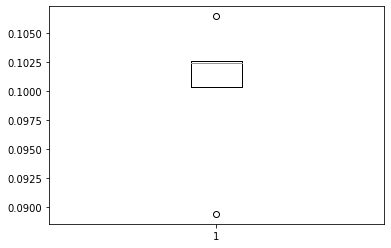

In [12]:
#Box plot de los mejores fitness del entrenamiento (de cada particion)
import matplotlib.pyplot as plt
plt.boxplot(mejores_fitnesses)
plt.show()

In [27]:
#Media de fitness de cada particion en el testeo
part_apts_mean

[0.054101032799191574,
 0.047460847676040675,
 0.04865683970428134,
 0.04500257487342316,
 0.053323383375346776]

In [28]:
#Validacion cruzada
print(f"MEDIA: {np.mean(part_apts_mean)}")
print(f"STD: {np.std(part_apts_mean)}")
print(f"MEDIANA: {np.median(part_apts_mean)}")

MEDIA: 0.04970893568565671
STD: 0.0034832567204890422
MEDIANA: 0.04865683970428134


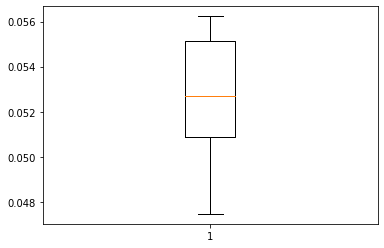

In [15]:
#Box plot de los mejores fitness del testeo (de cada particion)
plt.boxplot(part_apts_mean)
plt.show()

In [16]:
dir_tst = 'resultados/SM2/test/'
dir_trn = 'resultados/SM2/train/'

In [17]:
cd SRS/

d:\Documentos\ic_tps\SRS


In [18]:
# Guardar datos de testeo
np.save(dir_tst + 'v_apts.npy', part_apts)
np.save(dir_tst + 'mean_apts.npy', part_apts_mean)
np.save(dir_tst + 'std_apts.npy', part_apts_std)
# Guardar los datos de entrenamiento (alfa, psi, phi, umbral) de cada particion
np.save(dir_trn + 'v_alfa.npy', part_alfa)
np.save(dir_trn + 'v_beta.npy', part_beta)
np.save(dir_trn + 'v_gamma.npy', part_gamma)
np.save(dir_trn + 'v_best_fitness.npy', mejores_fitnesses)
np.save(dir_trn + 'v_part_fitness', v_part_fitness)

In [21]:
part_alfa

[0.20700497106370047,
 3.6860173835288896,
 0.2849633295880289,
 1.2809212052085635,
 0.9428547424663368]

In [22]:
part_beta

[0.6180422311816758,
 0.4383413739859512,
 0.2188072960998931,
 0.0632825634100312,
 0.8046727728142149]

In [23]:
part_gamma

[-2.089633342893453,
 -4.790785144819678,
 4.5018952614645436,
 0.5884683649879587,
 -4.57522622270065]

3